In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-data/Fraud.csv


In [2]:
sns.set(style = "whitegrid")

In [3]:
df = pd.read_csv("/kaggle/input/fraud-data/Fraud.csv")

In [4]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1593934,156,PAYMENT,28099.84,C740040786,75.00,0.00,M1457276521,0.00,0.00,0,0
3780181,280,PAYMENT,36522.05,C682181854,0.00,0.00,M1847650961,0.00,0.00,0,0
1749231,161,CASH_IN,462038.98,C304875449,99259.00,561297.98,C533510012,645606.63,183567.65,0,0
4669865,331,TRANSFER,854054.77,C1698660427,16281.29,0.00,C1987526143,2620758.70,3474813.47,0,0
1116278,130,PAYMENT,5262.85,C900606301,226464.84,221201.99,M1475055168,0.00,0.00,0,0


In [5]:
df.shape

(6362620, 11)

## **Data Cleaning**

In [6]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# Any missing values?
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
# Any duplicates?
df.duplicated().sum()

0

In [8]:
# Chech data types
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [9]:
# Optimize memory usage for large numeric columns
for col in df.columns:
    if df[col].dtype == "int64":
        df[col] = df[col].astype("int32")  # smaller integer type
    elif df[col].dtype == "float64":
        df[col] = df[col].astype("float32")  # smaller integer type

In [10]:
# Optimize memory usage for binary columns
binary_cols = ["isFraud", "isFlaggedFraud"]

for col in binary_cols:
    df[col] = df[col].astype("int8")

In [11]:
# Chech data types again
df.dtypes

step                int32
type               object
amount            float32
nameOrig           object
oldbalanceOrg     float32
newbalanceOrig    float32
nameDest           object
oldbalanceDest    float32
newbalanceDest    float32
isFraud              int8
isFlaggedFraud       int8
dtype: object

## **Exploratory Data Analysis(EDA)**

In [98]:
# Analyzing Class Distribution
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

The Data is highly Imbalanced, with Non-Fraud being the Majority Class



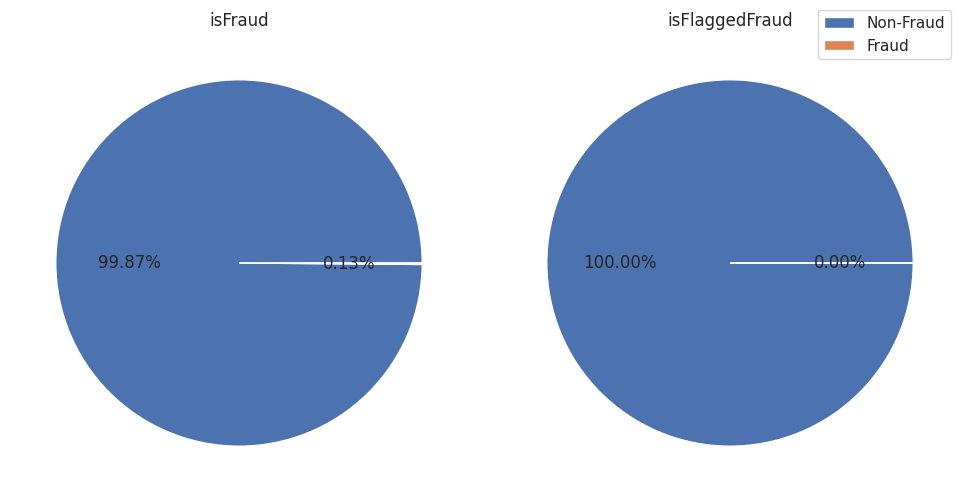

In [18]:
# isFraud vs isFlaggedFraud
print("The Data is highly Imbalanced, with Non-Fraud being the Majority Class")
print()

fig,ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].pie(df["isFraud"].value_counts(), autopct = "%0.2f%%")
ax[0].set_title("isFraud")

ax[1].pie(df["isFlaggedFraud"].value_counts(), autopct = "%0.2f%%")
ax[1].set_title("isFlaggedFraud")

plt.legend(["Non-Fraud", "Fraud"], loc = "upper right", bbox_to_anchor=(1, 1.07))

plt.tight_layout()
plt.show()

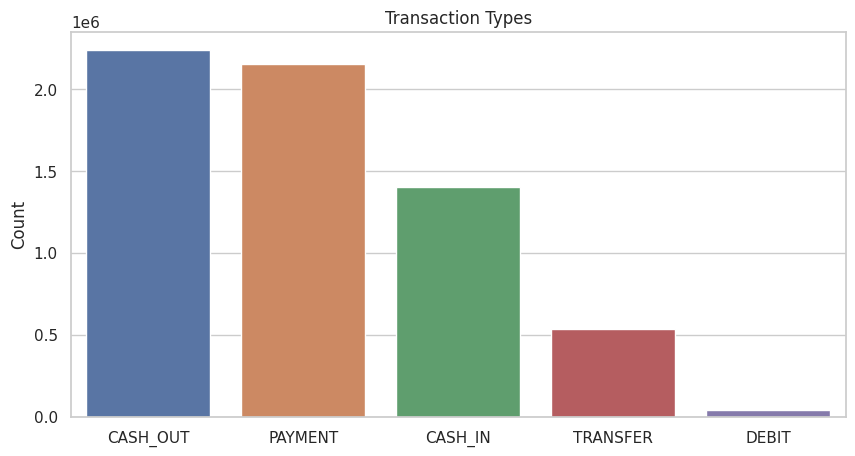

In [100]:
# Count of each transaction type
fig,ax = plt.subplots(figsize = (10, 5))

sns.countplot(data = df, x = "type", order = df["type"].value_counts().index, ax = ax)
ax.set(
    title = "Transaction Types",
    xlabel = "",
    ylabel = "Count"
)
plt.show()

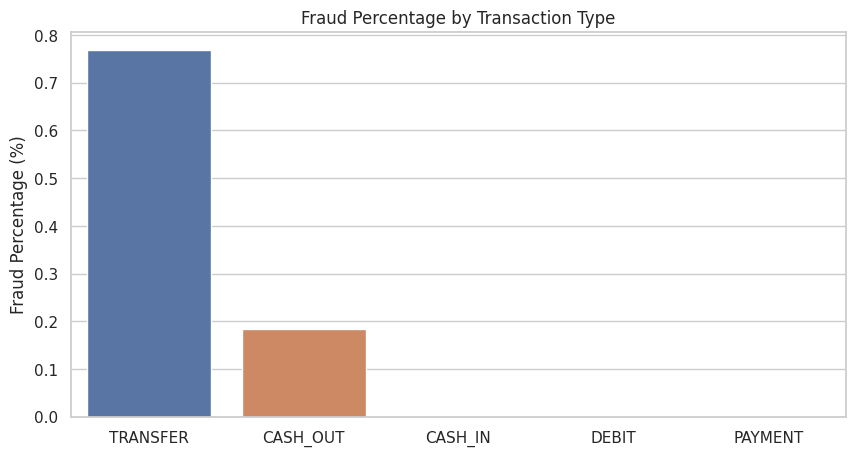

In [101]:
# Calculate fraud percentage per transaction type
fraud_percent = df.groupby("type")["isFraud"].mean().sort_values(ascending = False) * 100

# Plot
fig,ax = plt.subplots(figsize = (10, 5))

sns.barplot(x = fraud_percent.index, y = fraud_percent.values, ax = ax)
ax.set(
    title = "Fraud Percentage by Transaction Type",
    xlabel = "",
    ylabel = "Fraud Percentage (%)"
)
plt.show()

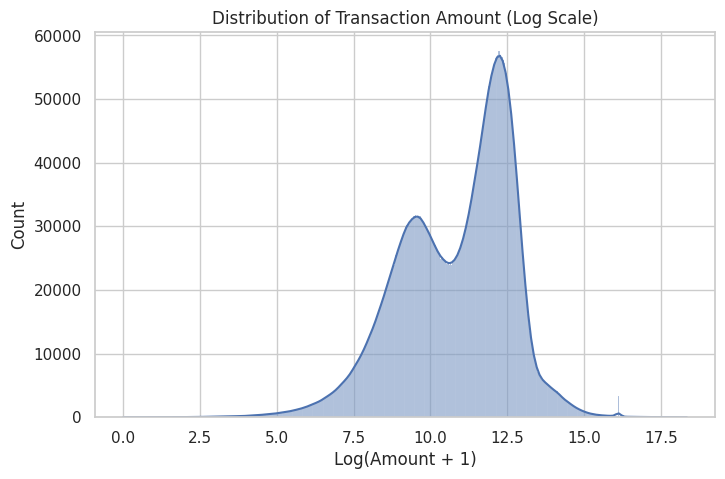

In [102]:
# Distribution of transaction amount (log scale)
fig,ax = plt.subplots(figsize = (8, 5))

sns.histplot(np.log1p(df["amount"]), kde = True, ax = ax)
ax.set(
    title = "Distribution of Transaction Amount (Log Scale)",
    xlabel = "Log(Amount + 1)",
    ylabel = "Count"
)
plt.show()

In [103]:
# Filter extreme outliers using the IQR rule
Q1 = df["amount"].quantile(0.25)
Q3 = df["amount"].quantile(0.75)

IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

df_filtered = df[(df["amount"] >= lower_limit) & (df["amount"] <= upper_limit)]

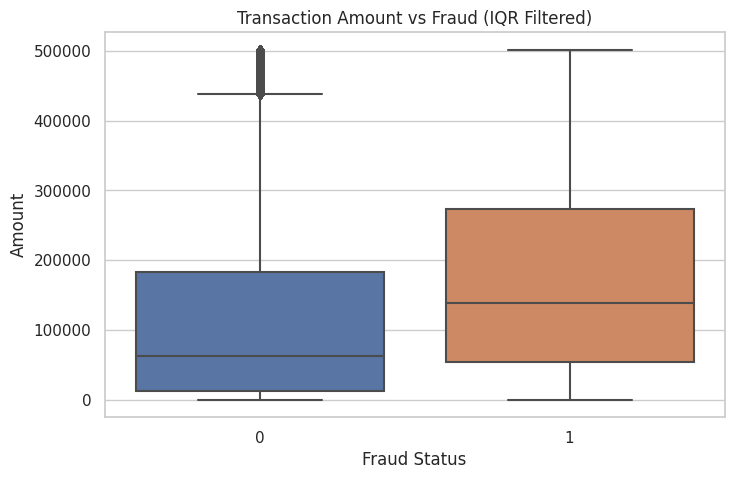

In [104]:
# Transaction amount vs isFraud (IQR filtered)
fig,ax = plt.subplots(figsize = (8, 5))

sns.boxplot(data = df_filtered, x = "isFraud", y = "amount", ax = ax)
ax.set(
    title = "Transaction Amount vs Fraud (IQR Filtered)",
    xlabel = "Fraud Status",
    ylabel = "Amount"
)
plt.show()

In [12]:
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [11]:
# Transactions where sender's balance goes negative (possible error or fraud)
(df["balanceDiffOrig"] < 0).sum()

1399252

In [12]:
# Transactions where receiver's balance goes negative (possible error or fraud)
(df["balanceDiffDest"] < 0).sum()

1238863

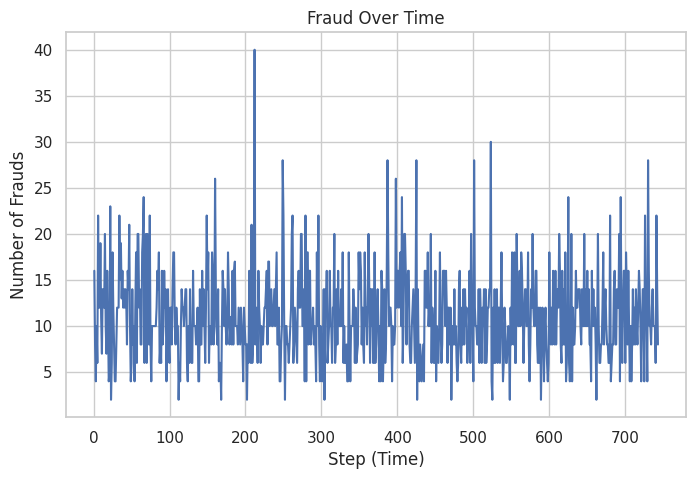

In [108]:
# Frauds per step(time)
frauds_per_step = df[df["isFraud"] == 1]["step"].value_counts().sort_index()

# Plot
fig,ax = plt.subplots(figsize = (8, 5))

ax.plot(frauds_per_step.index, frauds_per_step.values)
ax.set(
    title = "Fraud Over Time",
    xlabel = "Step (Time)",
    ylabel = "Number of Frauds"
)
ax.grid(True)
plt.show()

In [109]:
# Top customers by transaction count(senders & receivers)
top_senders = df["nameOrig"].value_counts().head(10)
top_receivers = df["nameDest"].value_counts().head(10)

In [110]:
print("Top Senders:")
top_senders

Top Senders:


nameOrig
C1530544995    3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1065307291    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In [111]:
print("Top Receivers:")
top_receivers

Top Receivers:


nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
C248609774     101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [112]:
# Top Fraud Customers
fraud_customers = df[df["isFraud"] == 1]["nameOrig"].value_counts().head(10)

In [113]:
print("Fraud Customers:")
fraud_customers

Fraud Customers:


nameOrig
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C137533655     1
C1118430673    1
C749981943     1
C1334405552    1
C467632528     1
Name: count, dtype: int64

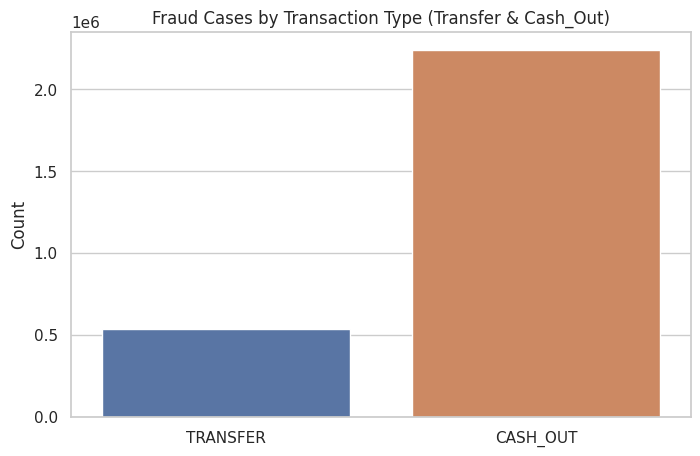

In [114]:
# Filter for TRANSFER & CASH_OUT transaction types
fraud_types = df[df["type"].isin(["TRANSFER","CASH_OUT"])]

# Plot
fig,ax = plt.subplots(figsize = (8, 5))

sns.countplot(data = fraud_types, x = "type", ax = ax)
ax.set(
    title = "Fraud Cases by Transaction Type (Transfer & Cash_Out)",
    xlabel = "",
    ylabel = "Count"
)
plt.show()

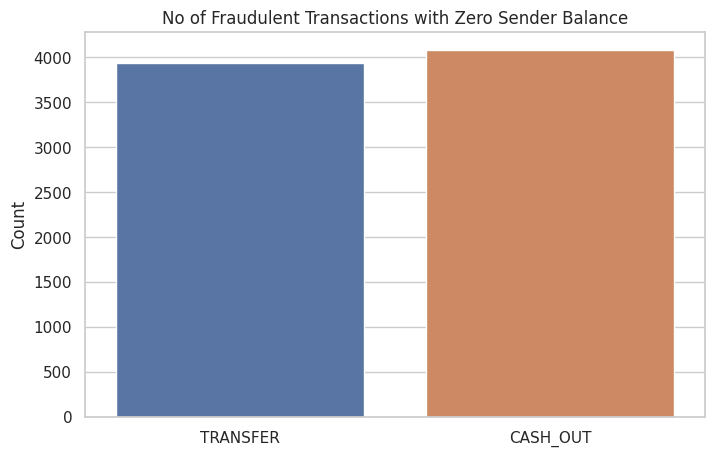

In [115]:
# Highlights suspicious transactions where the sender's balance drops to zero.
zero_after_transaction = df[(df["oldbalanceOrg"] > 0) & (df["newbalanceOrig"] == 0) & 
(df["type"].isin(["TRANSFER","CASH_OUT"])) &(df["isFraud"] == 1)]

# Plot
fig,ax = plt.subplots(figsize = (8, 5))

sns.countplot(data = zero_after_transaction, x = "type", ax = ax)
ax.set(
    title = "No of Fraudulent Transactions with Zero Sender Balance",
    xlabel = "",
    ylabel = "Count"
)
plt.show()

In [17]:
# Select numeric columns, excluding the binary columns
numeric_cols = df.select_dtypes(include = "number")
exclude_cols = ["isFraud", "isFlaggedFraud"]
cols_to_check = [col for col in numeric_cols if col not in exclude_cols]

In [18]:
# Detect outliers
print("Number of Outliers per column:")
print()

for col in cols_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers")

Number of Outliers per column:

step: 102688 outliers
amount: 338078 outliers
oldbalanceOrg: 1112507 outliers
newbalanceOrig: 1053391 outliers
oldbalanceDest: 786135 outliers
newbalanceDest: 738527 outliers
balanceDiffOrig: 2139300 outliers
balanceDiffDest: 886695 outliers
isLargeTransaction: 45487 outliers
sender_txn_count: 18611 outliers
receiver_txn_count: 191041 outliers
zero_balance_flag: 1188074 outliers
sender_amount_ratio: 1271316 outliers
receiver_amount_ratio: 820825 outliers


Strong Multi-Collinearity exists between some features, so one or both of them would be dropped


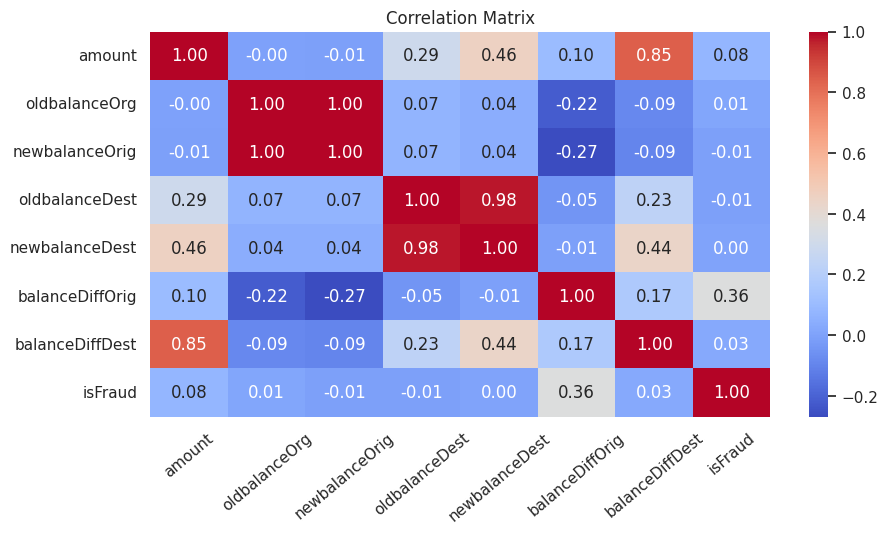

In [15]:
# Correlation Analysis
corr = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "balanceDiffOrig", "balanceDiffDest", "isFraud"]].corr()

print("Strong Multi-Collinearity exists between some features, so one or both of them would be dropped")
plt.subplots(figsize = (10, 5))
sns.heatmap(corr, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation Matrix")
plt.xticks(rotation = 40)
plt.show()

## **Feature Engineering**

In [13]:
# # Balance changes for sender and receiver
# df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
# df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

# Large transaction flag
threshold = df["amount"].mean() + 3 * df["amount"].std()
df["isLargeTransaction"] = (df["amount"] > threshold).astype("int32")

# Transaction count per sender
df["sender_txn_count"] = df.groupby("nameOrig")["nameOrig"].transform("count").astype("int32")
df["receiver_txn_count"] = df.groupby("nameDest")["nameDest"].transform("count").astype("int32")

# Zero balance flag for sender
df["zero_balance_flag"] = ((df["oldbalanceOrg"] > 0) & (df["newbalanceOrig"] == 0) & 
                           (df["type"].isin(["TRANSFER", "CASH_OUT"]))).astype("int32")
# Relative transaction amounts for sender and receiver
df["sender_amount_ratio"] = df["amount"] / (df["oldbalanceOrg"] + 1).astype("float32")
df["receiver_amount_ratio"] = df["amount"] / (df["oldbalanceDest"] + 1).astype("float32")

In [15]:
df.dtypes

step                       int32
type                      object
amount                   float32
nameOrig                  object
oldbalanceOrg            float32
newbalanceOrig           float32
nameDest                  object
oldbalanceDest           float32
newbalanceDest           float32
isFraud                     int8
isFlaggedFraud              int8
balanceDiffOrig          float32
balanceDiffDest          float32
isLargeTransaction         int32
sender_txn_count           int32
receiver_txn_count         int32
zero_balance_flag          int32
sender_amount_ratio      float32
receiver_amount_ratio    float32
dtype: object

## **Data Splitting**

In [16]:
# Separate the data into feature and target variables
X = df[["type","amount","balanceDiffOrig","balanceDiffDest","isLargeTransaction","sender_txn_count","receiver_txn_count","zero_balance_flag","sender_amount_ratio","receiver_amount_ratio"]]
y = df["isFraud"]

In [17]:
# Split the data to train, validation, and test sets
from sklearn.model_selection import train_test_split

# First generate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.5,  # 5% test
    stratify = y, 
    random_state = 42)

# Then generate train + validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, 
    y_temp,
    test_size = 0.10,  # 10% Validation
    stratify = y_temp,
    random_state = 42)

In [18]:
print(X_train.shape, X_test.shape, X_val.shape, y_val.shape, y_train.shape, y_test.shape)

(2863179, 10) (3181310, 10) (318131, 10) (318131,) (2863179,) (3181310,)


## **Data Preprocessing**

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [20]:
# Column types
cat_cols = ["type"]
num_cols = [col for col in X.columns if col not in cat_cols]

# Preprocessing pipeline
full_preprocessing  = ColumnTransformer(transformers = [
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop = "first", sparse_output = False), cat_cols)
])

In [21]:
# Fit and transform training data
X_train_trf = full_preprocessing.fit_transform(X_train)
# Transform validation data
X_val_trf = full_preprocessing.transform(X_val)
# Transform test data
X_test_trf = full_preprocessing.transform(X_test)

In [22]:
print(X_train_trf.shape, X_val_trf.shape, X_test_trf.shape)

(2863179, 13) (318131, 13) (3181310, 13)



## **Modeling**

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay, make_scorer, accuracy_score, precision_score, 
recall_score, f1_score, roc_auc_score, precision_recall_curve)

In [24]:
# Model dict
models = {
    "Logistic Regression": LogisticRegression(max_iter = 1000, class_weight = "balanced", random_state = 42, n_jobs = -1),
    "Random Forest": RandomForestClassifier(n_estimators = 100, class_weight = "balanced", random_state = 42, n_jobs = -1),
    "XGBoost": XGBClassifier(n_estimators = 200, tree_method = "hist", use_label_encoder = False, eval_metric = "logloss", 
              scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(), random_state = 42, n_jobs = -1)
}

In [25]:
# Model dict(pipeline)
model_pipeline = {
    "Logistic Regression": Pipeline([
        ("preprocessing", full_preprocessing),
        ("clf", LogisticRegression(max_iter = 1000, class_weight = "balanced", random_state = 42, n_jobs = -1))
    ]),

    "Random Forest": Pipeline([
        ("preprocessing", full_preprocessing),
        ("clf1", RandomForestClassifier(n_estimators = 100, class_weight = "balanced", random_state = 42, n_jobs = -1))
    ]),

    "XGBoost": Pipeline([
        ("preprocessing", full_preprocessing),
        ("clf2", XGBClassifier(n_estimators = 200, tree_method = "hist", use_label_encoder = False, eval_metric = "logloss", 
              scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(), random_state = 42, n_jobs = -1))
    ])
}

In [26]:
# A Function to fit and score the models
def fit_and_score(models, X_train, y_train, X_test, y_test):
    """
    Fits each pipeline model, computes metrics, and returns a DataFrame.
    """
    metrics = []

    for name, model in models.items():
        print(f"Training {name}...")
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Predict labels
        y_pred = model.predict(X_test)
        
        # Predict probabilities
        y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
        
        # Compute metrics
        metrics.append({
            "Model": name,
            "Accuracy": round(accuracy_score(y_test, y_pred), 4),
            "Precision": round(precision_score(y_test, y_pred, zero_division = 0), 4),
            "Recall": round(recall_score(y_test, y_pred, zero_division = 0), 4),
            "F1_Score": round(f1_score(y_test, y_pred), 4),
            "ROC-AUC": round(roc_auc_score(y_test, y_prob), 4) if y_prob is not None else None
        })
    
    # Return as DataFrame
    return pd.DataFrame(metrics).set_index("Model")

In [25]:
performance_df = fit_and_score(models, X_train_trf, y_train, X_val_trf, y_val)

Training Logistic Regression...
Training Random Forest...
Training XGBoost...


In [26]:
performance_df

,Accuracy,Precision,Recall,F1_Score,ROC-AUC
Model,,,,,
Logistic Regression,0.9570,0.0291,0.9951,0.0565,0.9957
Random Forest,0.9994,0.7374,0.8881,0.8057,0.9997
XGBoost,0.9997,0.8126,0.9708,0.8847,1.0000


In [27]:
performance_df1 = performance_df[["Precision", "Recall", "F1_Score"]].reset_index().melt(id_vars = "Model", var_name = "Metric", value_name = "Value")

In [28]:
performance_df1

,Model,Metric,Value
0,Logistic Regression,Precision,0.0291
1,Random Forest,Precision,0.7374
2,XGBoost,Precision,0.8126
3,Logistic Regression,Recall,0.9951
4,Random Forest,Recall,0.8881
5,XGBoost,Recall,0.9708
6,Logistic Regression,F1_Score,0.0565
7,Random Forest,F1_Score,0.8057
8,XGBoost,F1_Score,0.8847


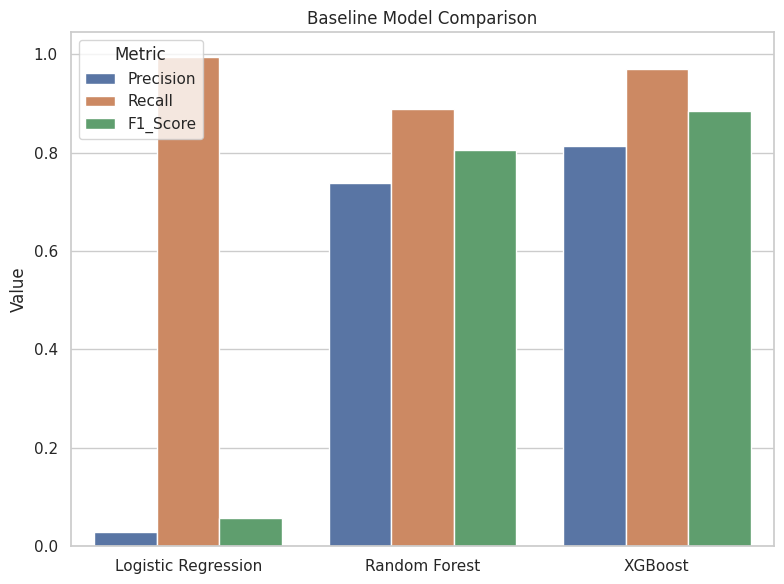

In [29]:
# Model Comparison
fig,ax = plt.subplots(figsize=(8,6))

sns.barplot(x = "Model", y = "Value", hue = "Metric", data = performance_df1, ax = ax)
ax.set(
    title = "Baseline Model Comparison",
    xlabel = "",
    ylabel = "Value"
)
ax.legend(title = "Metric", loc = "best")
# ax.tick_params(axis = 'x', rotation = 40)

plt.tight_layout()
plt.show()

## **Model Optimization**

In [24]:
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, RandomizedSearchCV

In [36]:
# Repeated Stratified K-Fold
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

# Metrics to evaluate
scoring = ["precision", "recall", "f1", "roc_auc"]

# Function for cross validation
def cross_validate_models(models, X, y):
    """
    Performs cross-validation on given models and returns mean ± std metrics.
    """
    results = {}
    
    for name, model in models.items():
        print(f"Cross validating {name}...")

        # Cross validate
        scores = cross_validate(model, X, y, cv = cv, scoring = scoring, n_jobs = -1)
        
        metrics = {}
        
        for m in scoring:
            mean = scores[f"test_{m}"].mean()
            std = scores[f"test_{m}"].std()
            metrics[m] = f"{mean:.4f} ± {std:.4f}"  # mean ± std
        results[name] = metrics
    
    return pd.DataFrame(results).T

# Run CV
cv_results = cross_validate_models(model_pipeline, X_train, y_train)
cv_results

Cross validating Logistic Regression...
Cross validating Random Forest...
Cross validating XGBoost...


,precision,recall,f1,roc_auc
Logistic Regression,0.0295 ± 0.0016,0.9893 ± 0.0038,0.0573 ± 0.0029,0.9946 ± 0.0012
Random Forest,0.7229 ± 0.0403,0.8692 ± 0.0203,0.7882 ± 0.0192,0.9969 ± 0.0017
XGBoost,0.7840 ± 0.1139,0.9554 ± 0.0264,0.8582 ± 0.0794,0.9983 ± 0.0012


In [29]:
# Param Grid for Random Forest, XGBoost
param_grid = {
    "Random Forest": {
        "clf1__n_estimators": [200, 400],
        "clf1__max_depth": [10, 20, None],
        "clf1__min_samples_split": [2, 10],
        "clf1__min_samples_leaf": [1, 5, 10],
        "clf1__max_features": ["sqrt", 0.3],
        "clf1__bootstrap": [True]
    },
    "XGBoost": {
        "clf2__n_estimators": [300, 500],
        "clf2__max_depth": [4, 6, 8],
        "clf2__learning_rate": [0.05, 0.1],
        "clf2__subsample": [0.8, 1],
        "clf2__colsample_bytree": [0.8, 1],
        "clf2__gamma": [0, 0.1],
        "clf2__reg_lambda": [1, 5],
        "clf2__reg_alpha": [0, 1],
        "clf2__tree_method": ["hist"]  # or "gpu_hist"
    }
}

In [30]:
# Use a sample of training data for faster hypertuning(Stratified Sampling)
X_sample, _, y_sample, _ = train_test_split(
    X_train,
    y_train,
    train_size = 0.1,    # Use 10% of training data for tuning
    stratify = y_train,  # Preserve class distribution
    random_state = 42
)

In [40]:
# Repeated Stratified K-Fold for imbalanced data
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

# Define multiple metrics
scoring = {
    "precision": make_scorer(precision_score, zero_division = 0),
    "recall": make_scorer(recall_score, zero_division = 0),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score, needs_proba = True)
}

# Loop through model_pipeline
for name, pipeline in model_pipeline.items():
    if name == "Logistic Regression":
        print(f"\nSkipping {name} (tuning won't help).")
        continue

    print(f"\n Tuning {name} on sampled data...")

    grid = RandomizedSearchCV(
        estimator = pipeline,
        param_distributions = param_grid[name],
        n_iter = 20,
        scoring = scoring,   # multiple metrics
        refit = "f1",   # main metric
        cv = cv,
        random_state = 42,
        error_score = "raise",
        n_jobs = -1,
        verbose = True
    )

    # Fit on sampled training data
    grid.fit(X_sample, y_sample)

    # Predict on full validation data
    y_pred = grid.predict(X_val)
    y_prob = grid.predict_proba(X_val)[:, 1] if hasattr(grid, "predict_proba") else None

    # Compute metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division = 0)
    recl = recall_score(y_val, y_pred, zero_division = 0)
    f1_scr = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_prob) if y_prob is not None else None

    # Display results
    print(f"\n {name} Results:")
    print("Best Parameters:", grid.best_params_)
    print(f"Best CV F1 Score: {grid.best_score_:.4f}")
    print(f"Validation F1 Score: {f1_scr:.4f}")
    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation Precision: {prec:.4f}")
    print(f"Validation Recall: {recl:.4f}")
    if roc_auc is not None:
        print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print("-" * 40)


Skipping Logistic Regression (tuning won't help).

 Tuning Random Forest on sampled data...
Fitting 10 folds for each of 20 candidates, totalling 200 fits

 Random Forest Results:
Best Parameters: {'clf1__n_estimators': 400, 'clf1__min_samples_split': 2, 'clf1__min_samples_leaf': 1, 'clf1__max_features': 'sqrt', 'clf1__max_depth': None, 'clf1__bootstrap': True}
Best CV F1 Score: 0.8282
Validation F1 Score: 0.8167
Validation Accuracy: 0.9996
Validation Precision: 0.9515
Validation Recall: 0.7153
Validation ROC-AUC: 0.9977
----------------------------------------

 Tuning XGBoost on sampled data...
Fitting 10 folds for each of 20 candidates, totalling 200 fits

 XGBoost Results:
Best Parameters: {'clf2__tree_method': 'hist', 'clf2__subsample': 0.8, 'clf2__reg_lambda': 1, 'clf2__reg_alpha': 1, 'clf2__n_estimators': 500, 'clf2__max_depth': 8, 'clf2__learning_rate': 0.05, 'clf2__gamma': 0.1, 'clf2__colsample_bytree': 1}
Best CV F1 Score: 0.8776
Validation F1 Score: 0.7901
Validation Accura

## **Model Assessment**

In [27]:
# Generate a separate set for calibration and threshold tuning
X_train_final, X_cal, y_train_final, y_cal = train_test_split(
    X_temp, 
    y_temp, 
    test_size = 0.10,         # 10% for calibration + threshold tuning
    stratify = y_temp, 
    random_state = 42
)

In [28]:
print(X_train_final.shape, X_cal.shape, y_train_final.shape, y_cal.shape)

(2863179, 10) (318131, 10) (2863179,) (318131,)


In [29]:
from collections import Counter

# Dynamically compute scale_pos_weight
counter = Counter(y_train_final)
spw = counter[0] / max(1, counter[1])  # neg / pos

print(f"Dynamic scale_pos_weight: {spw:.2f}")

# Final model
final_xgb = Pipeline([
        ("preprocessing", full_preprocessing),
        ("xgbc", XGBClassifier(n_estimators = 600, tree_method = "hist", subsample = 0.8, reg_lambda = 5, reg_alpha = 3, max_depth = 7, learning_rate = 0.07, gamma = 0.1, 
                               colsample_bytree = 0.8, use_label_encoder = False, eval_metric = "aucpr", scale_pos_weight = spw))
])

Dynamic scale_pos_weight: 773.67


In [30]:
# Train the final model
final_xgb.fit(X_train_final, y_train_final)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'balanceDiffOrig',
                                                   'balanceDiffDest',
                                                   'isLargeTransaction',
                                                   'sender_txn_count',
                                                   'receiver_txn_count',
                                                   'zero_balance_flag',
                                                   'sender_amount_ratio',
                                                   'receiver_amount_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['type'])])),
                ('xgbc',
                 XGBClassif...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.07,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=600, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [31]:
# Predictions
y_pred = final_xgb.predict(X_test)
y_proba = final_xgb.predict_proba(X_test)[:, 1] if hasattr(final_xgb, "predict_proba") else None

In [32]:
# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3177204
           1       0.78      0.99      0.87      4106

    accuracy                           1.00   3181310
   macro avg       0.89      0.99      0.94   3181310
weighted avg       1.00      1.00      1.00   3181310

ROC-AUC Score: 0.9996401994438519


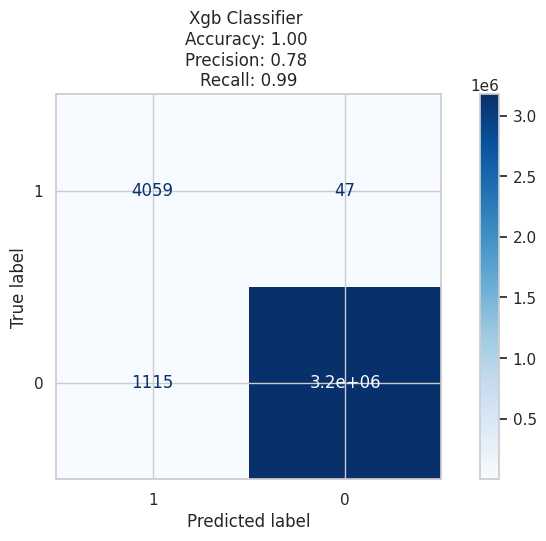

In [33]:
# Accuracy, Precision, and Recall Scores for Xgb Classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division = 0)
recall = recall_score(y_test, y_pred, zero_division = 0)

# Set up the plot
fig,ax = plt.subplots(figsize = (10, 5))

# Plot the Confusion Matrix for Xgb Classifier
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = ax, cmap = "Blues")
ax.set_title(f"Xgb Classifier \nAccuracy: {accuracy:.2f} \nPrecision: {precision:.2f} \nRecall: {recall:.2f}")
ax.invert_yaxis()
ax.invert_xaxis()

plt.show()

## **Model Calibration**

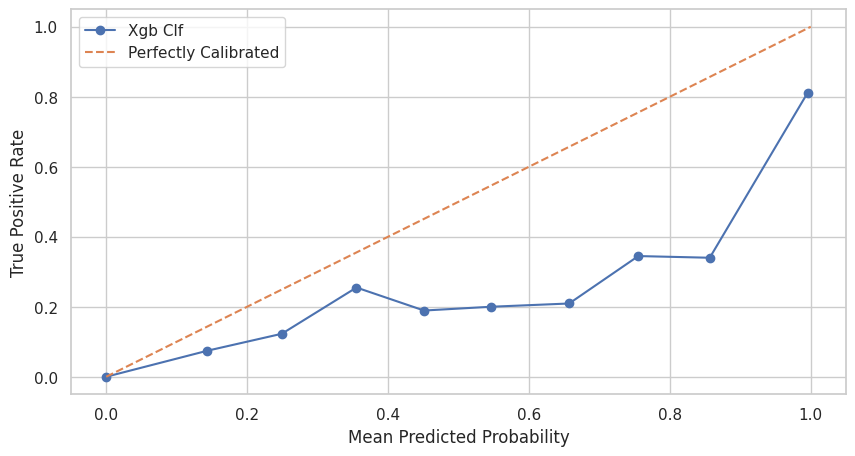

Brier Score: 0.0003


In [34]:
# Check Calibration of the Xgb Classifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

probs = final_xgb.predict_proba(X_test)[:, 1]

true_prob, mean_predicted_prob = calibration_curve(y_test, probs, n_bins = 10)    # Output: Fraction of positives(true_rate), Mean predicted probability

fig,ax = plt.subplots(figsize = (10, 5))

ax.plot(mean_predicted_prob, true_prob, marker = "o", label = "Xgb Clf")
ax.plot([0,1], [0,1], linestyle = "--", label = "Perfectly Calibrated")
ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("True Positive Rate")
ax.legend()

plt.show()

brier = brier_score_loss(y_test, probs)
print(f'Brier Score: {brier:.4f}')

In [35]:
# Calibrate the Xgb Classifier
from sklearn.calibration import CalibratedClassifierCV

calibrated_xgb = CalibratedClassifierCV(base_estimator = final_xgb, method = "isotonic", cv = 7)
calibrated_xgb.fit(X_cal, y_cal)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('preprocessing',
                                                       ColumnTransformer(transformers=[('num',
                                                                                        StandardScaler(),
                                                                                        ['amount',
                                                                                         'balanceDiffOrig',
                                                                                         'balanceDiffDest',
                                                                                         'isLargeTransaction',
                                                                                         'sender_txn_count',
                                                                                         'receiver_txn_count',
                                                                                         'zero_balance_flag',
                                                                                         'sender_amount_ratio',
                                                                                         'receiver_amount_ratio']),
                                                                                       ('cat',
                                                                                        OneHotEncoder(drop='first',
                                                                                                      sparse_output=...
                                                                     importance_type=None,
                                                                     interaction_constraints=None,
                                                                     learning_rate=0.07,
                                                                     max_bin=None,
                                                                     max_cat_threshold=None,
                                                                     max_cat_to_onehot=None,
                                                                     max_delta_step=None,
                                                                     max_depth=7,
                                                                     max_leaves=None,
                                                                     min_child_weight=None,
                                                                     missing=nan,
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=600,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     random_state=None, ...))]),
                       cv=7, method='isotonic')

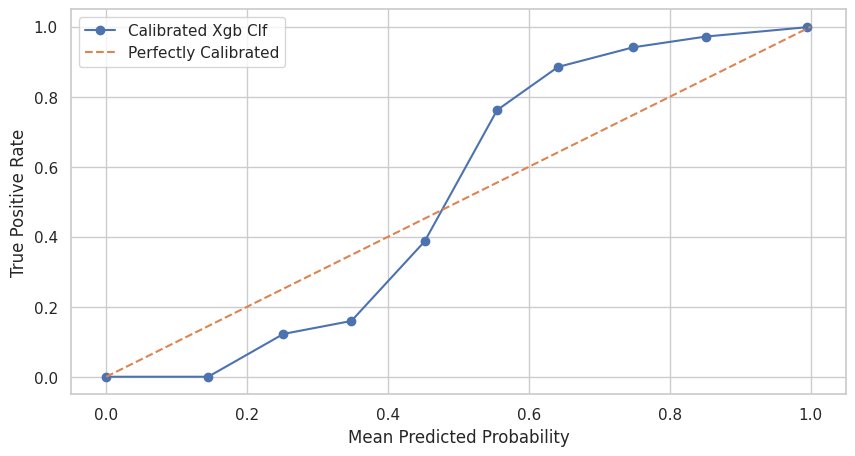

Brier Score: 0.0003


In [36]:
# Now let's check the Calibration of Calibrated Xgb Classifier
probs_cal = calibrated_xgb.predict_proba(X_test)[:, 1] 

true_prob_cal, mean_predicted_prob_cal = calibration_curve(y_test, probs_cal, n_bins = 10)    # Output: Fraction of positives(true_rate), Mean predicted probability

fig,ax = plt.subplots(figsize = (10, 5))

ax.plot(mean_predicted_prob_cal, true_prob_cal, marker = "o", label = "Calibrated Xgb Clf")
ax.plot([0,1], [0,1], linestyle = "--", label = "Perfectly Calibrated")
ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("True Positive Rate")
ax.legend()

plt.show()

brier = brier_score_loss(y_test, probs)
print(f'Brier Score: {brier:.4f}')

In [37]:
# Predictions (Calibrated Xgb Classifier)
y_pred_cal = calibrated_xgb.predict(X_test)
y_proba_cal = calibrated_xgb.predict_proba(X_test)[:, 1] if hasattr(calibrated_xgb, "predict_proba") else None

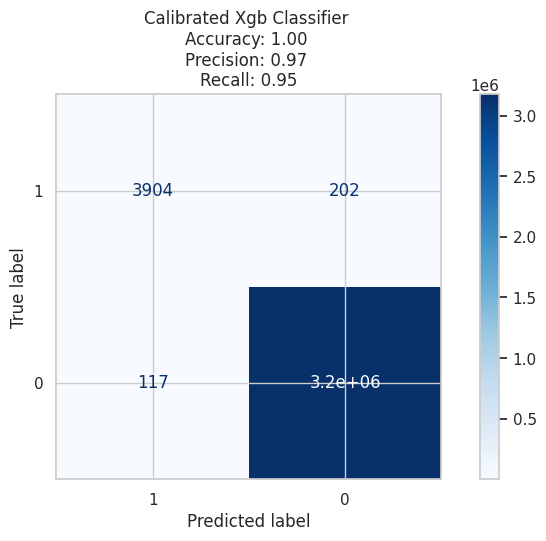

In [38]:
# Accuracy, Precision, and Recall Scores for Calibrated Xgb Classifier
accuracy_cal = accuracy_score(y_test, y_pred_cal)
precision_cal = precision_score(y_test, y_pred_cal, zero_division = 0)
recall_cal = recall_score(y_test, y_pred_cal, zero_division = 0)

# Set up the plot
fig,ax = plt.subplots(figsize = (10, 5))

# Plot the Confusion Matrix for Calibrated Xgb Classifier
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cal, ax = ax, cmap = "Blues")
ax.set_title(f"Calibrated Xgb Classifier \nAccuracy: {accuracy_cal:.2f} \nPrecision: {precision_cal:.2f} \nRecall: {recall_cal:.2f}")
ax.invert_yaxis()
ax.invert_xaxis()

plt.show()

# **Threshold Tuning**

In [39]:
# Generate fraud probabilities on the calibration and test sets
y_probs_cal = calibrated_xgb.predict_proba(X_cal)[:, 1]
y_probs_test = calibrated_xgb.predict_proba(X_test)[:, 1]
y_cal_arr = np.array(y_cal)

In [40]:
# Compute precision–recall curve
precision, recall, thresholds = precision_recall_curve(y_cal_arr, y_probs_cal)
precision, recall = precision[:-1], recall[:-1]  # remove last point to match threshold array

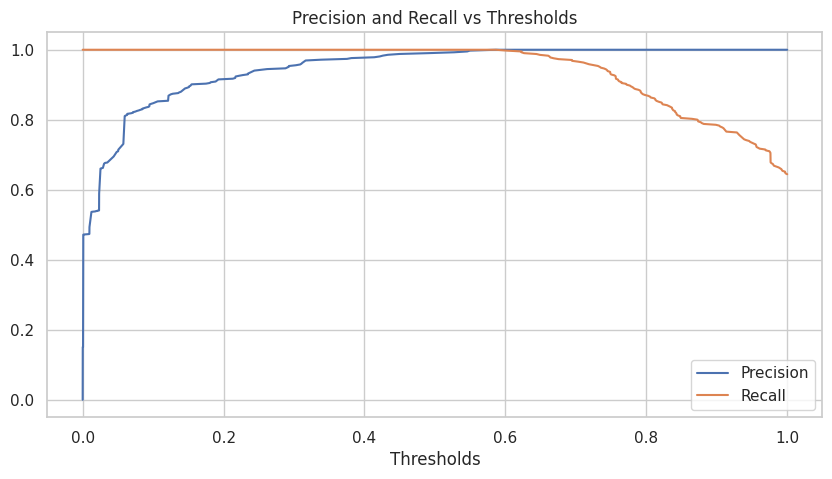

In [41]:
# Plot Precision and Recall vs Thresholds
fig,ax = plt.subplots(figsize = (10, 5))

ax.plot(thresholds, precision, label = 'Precision')
ax.plot(thresholds, recall, label = 'Recall')
ax.set(
    title = "Precision and Recall vs Thresholds",
    xlabel = "Thresholds"
)
ax.grid(True)
ax.legend()
plt.show()

In [42]:
# Find the threshold that meets target recall and precision
target_recall = 0.99
target_precision = 0.97

valid_idx = np.where((recall >= target_recall) & (precision >= target_precision))[0]

best_idx = valid_idx[0]

best_threshold = thresholds[best_idx]
print("Selected threshold and metrics on the calibration set:")
print(f"Threshold: {best_threshold:.3f}, Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}")

Selected threshold and metrics on the calibration set:
Threshold: 0.338, Precision: 0.972, Recall: 1.000


In [43]:
# Apply threshold to the test set
y_pred_thr = (y_probs_test >= best_threshold).astype(int)

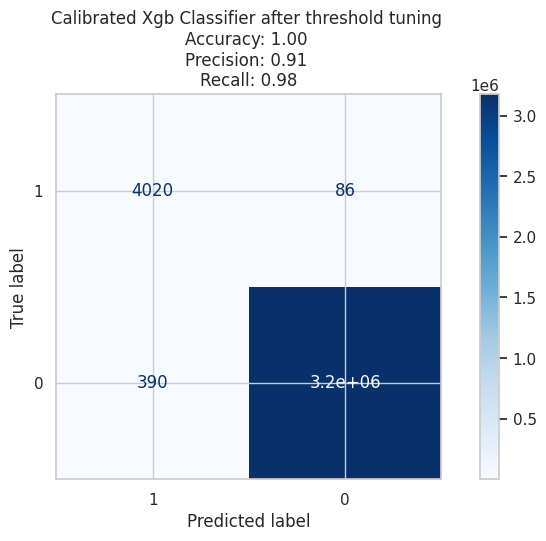

In [44]:
# Accuracy, Precision, and Recall Scores for Calibrated Xgb Classifier after threshold tuning
accuracy_thr = accuracy_score(y_test, y_pred_thr)
precision_thr = precision_score(y_test, y_pred_thr, zero_division = 0)
recall_thr = recall_score(y_test, y_pred_thr, zero_division = 0)

# Set up the plot
fig,ax = plt.subplots(figsize = (10, 5))

# Plot the Confusion Matrix for Calibrated Xgb Classifier after threshold tuning
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thr, ax = ax, cmap = "Blues")
ax.set_title(f"Calibrated Xgb Classifier after threshold tuning \nAccuracy: {accuracy_thr:.2f} \nPrecision: {precision_thr:.2f} \nRecall: {recall_thr:.2f}")
ax.invert_yaxis()
ax.invert_xaxis()

plt.show()

## **Save the Model**

In [45]:
import pickle

# Save the Calibrated Xgb Classifier with the tuned threshold
with open("calibrated_xgb_clf_with_tuned_threshold.pkl", "wb") as f:
    pickle.dump({
        "pipeline": calibrated_xgb,
        "threshold": best_threshold
    }, f)